In [81]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

# MNIST data

In [137]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
print(np.shape(mnist.train.images))
print(np.shape(mnist.train.labels))

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
(55000, 784)
(55000, 10)


[[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


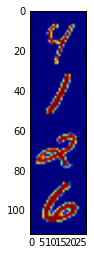

In [141]:
data_size = 300
def get_batch(batch_size):
    idx1 = np.random.choice(data_size, batch_size)
    idx2 = np.random.choice(data_size, batch_size)
    
    img1 = mnist.train.images[idx1]
    img2 = mnist.train.images[idx2]
    cls1 = mnist.train.labels[idx1]
    cls2 = mnist.train.labels[idx2]
        
    return img1, cls1, img2, cls2

# test data
bs = 4
img,cls,_,_ = get_batch(bs)
img = img.reshape([bs*28,28])
plt.imshow(img);
print(cls)
print(img)

# Network
loss: https://academo.org/demos/3d-surface-plotter/?expression=abs(x)%2Fabs(y)%2Babs(y)%2Fabs(x)&xRange=-50%2C+50&yRange=-50%2C+50&resolution=25


In [152]:
input_size = 28*28
class_num = 10

embedding_size = 64
batch_size = 128

tf.reset_default_graph()
graph = tf.Graph()

with graph.as_default():
    
    def NetworkA(inputs):
        embeddings = tf.Variable(tf.random_uniform([input_size, embedding_size], -1.0, 1.0), "embeddings")
        outputs = tf.matmul(inputs, embeddings)
        return outputs
    
    def NetworkB(inputs):
        inputs =  tf.reshape(inputs, [-1, 28, 28, 1])
        conv1 = tf.layers.conv2d(
            inputs=inputs,
            filters=32,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu)
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
        conv2 = tf.layers.conv2d(
            inputs=pool1,
            filters=64,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu)
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
        pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
        dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
        outputs = tf.layers.dense(inputs=dense, units=embedding_size)
        return outputs

    image1 = tf.placeholder(tf.float32, [batch_size, input_size])
    image2 = tf.placeholder(tf.float32, [batch_size, input_size])
    class1 = tf.placeholder(tf.float32, [batch_size, class_num])
    class2 = tf.placeholder(tf.float32, [batch_size, class_num])

    embed1 = NetworkB(image1)
    embed2 = NetworkB(image2)
    
    e = 1e-10
    
    ne = tf.reduce_sum(embed1)**2 + tf.reduce_sum(embed2)**2 + e
    de = (tf.reduce_sum((embed1-embed2)**2, axis=1) + e) / ne
    nc = tf.reduce_sum(class1)**2 + tf.reduce_sum(class1)**2
    dc = (tf.reduce_sum((class1-class2)**2, axis=1) + e) / nc
    
    loss = tf.reduce_mean(de/dc + dc/de)
    
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)

# Let's train

In [ ]:
%%time
num_steps = 10000

with tf.Session(graph=graph) as sess:
    try:
        tf.global_variables_initializer().run()
        print('Initialized')
        average_loss = 0

        for step in range(num_steps+1):
            img1, cls1, img2, cls2 = get_batch(batch_size)
            _, current_loss = sess.run([optimizer, loss], feed_dict = {
                image1 : img1,
                image2 : img2,
                class1 : cls1,
                class2 : cls2,

            })
            average_loss += current_loss
            every = 100
            if step % every == 0:
                if step > 0:
                    average_loss = average_loss / every
                    clear_output(True)
                    print ("step = %4d, average_loss = %.2e" % (step, average_loss))
                average_loss = 0
    except KeyboardInterrupt:
        pass

step = 2100, average_loss = 7.90e+04


# Visualization

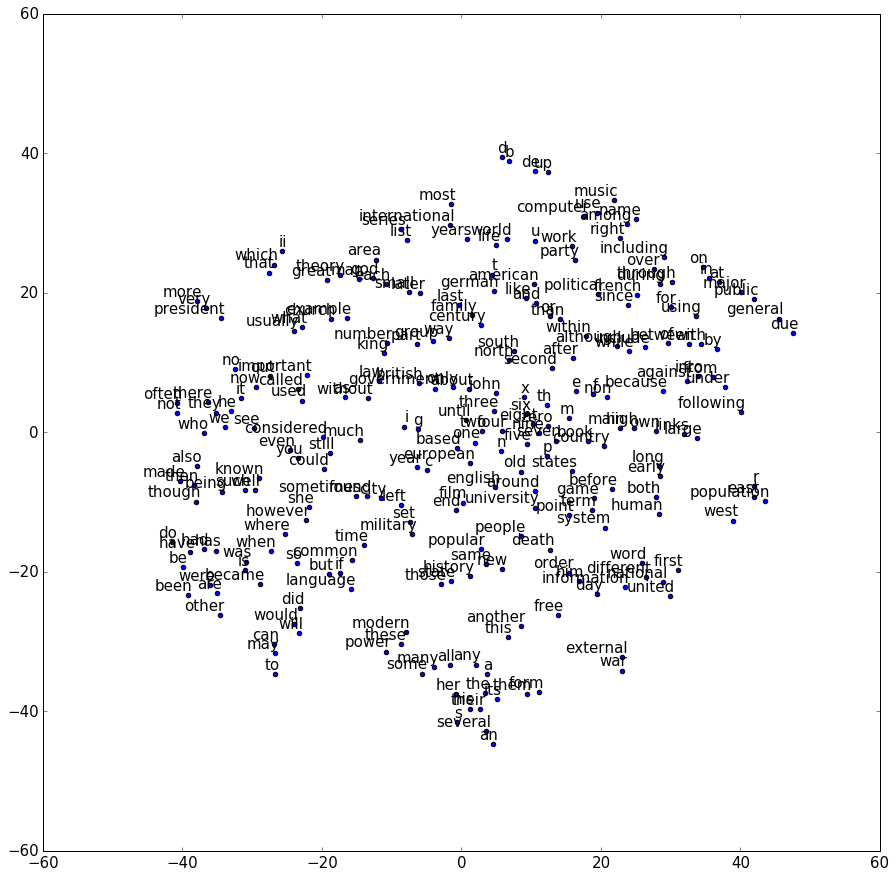

In [14]:
from sklearn.manifold import TSNE

num_points = 250

data = get_batch(num_points)[0]

tsne = TSNE(perplexity=10, n_components=2, init="pca", n_iter=5000)
two_d_embeddings = tsne.fit_transform(data[1:num_points+1, :])

plt.figure(figsize=(15,15))
words = [index_to_word[i] for i in range(1, num_points+1)]

for i, label in enumerate(words):
    x, y = two_d_embeddings[i, :]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords="offset points",
                   ha="right", va="bottom")
plt.show()

# Test similarities